In [1]:
import tensorflow as tf
from tensorflow.keras import layers

# import keras
# from tensorflow import keras
# from keras import backend
# from keras import constraints
# from keras import initializers
# from keras import regularizers
# from keras.engine import base_layer_utils
# from keras.engine.base_layer import Layer
import numpy as np
from tensorflow.keras.utils import plot_model
from keras import backend
from keras import constraints
from keras import initializers
from keras import regularizers
from keras.engine import base_layer_utils


2023-06-19 23:28:39.540866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 23:28:40.334234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
class Custome_Embedding(layers.Layer):
    """Turns positive integers (indexes) into dense vectors of fixed size.

    e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

    This layer can only be used on positive integer inputs of a fixed range. The
    tf.keras.layers.TextVectorization, tf.keras.layers.StringLookup,
    and tf.keras.layers.IntegerLookup preprocessing layers can help prepare
    inputs for an Embedding layer.

    This layer accepts tf.Tensor, tf.RaggedTensor and tf.SparseTensor
    input.

    Example:

    >>> model = tf.keras.Sequential()
    >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
    >>> # The model will take as input an integer matrix of size (batch,
    >>> # input_length), and the largest integer (i.e. word index) in the input
    >>> # should be no larger than 999 (vocabulary size).
    >>> # Now model.output_shape is (None, 10, 64), where None is the batch
    >>> # dimension.
    >>> input_array = np.random.randint(1000, size=(32, 10))
    >>> model.compile('rmsprop', 'mse')
    >>> output_array = model.predict(input_array)
    >>> print(output_array.shape)
    (32, 10, 64)

    Args:
      input_dim: Integer. Size of the vocabulary,
        i.e. maximum integer index + 1.
      output_dim: Integer. Dimension of the dense embedding.
      embeddings_initializer: Initializer for the embeddings
        matrix (see keras.initializers).
      embeddings_regularizer: Regularizer function applied to
        the embeddings matrix (see keras.regularizers).
      embeddings_constraint: Constraint function applied to
        the embeddings matrix (see keras.constraints).
      mask_zero: Boolean, whether or not the input value 0 is a special
        "padding" value that should be masked out. This is useful when using
        recurrent layers which may take variable length input. If this is
        True, then all subsequent layers in the model need to support masking
        or an exception will be raised. If mask_zero is set to True, as a
        consequence, index 0 cannot be used in the vocabulary (input_dim should
        equal size of vocabulary + 1).
      input_length: Length of input sequences, when it is constant.
        This argument is required if you are going to connect
        Flatten then Dense layers upstream
        (without it, the shape of the dense outputs cannot be computed).
      sparse: If True, calling this layer returns a tf.SparseTensor. If False,
        the layer returns a dense tf.Tensor. For an entry with no features in
        a sparse tensor (entry with value 0), the embedding vector of index 0 is
        returned by default.

    Input shape:
      2D tensor with shape: (batch_size, input_length).

    Output shape:
      3D tensor with shape: (batch_size, input_length, output_dim).

    *Note on variable placement:*
    By default, if a GPU is available, the embedding matrix will be placed on
    the GPU. This achieves the best performance, but it might cause issues:

    - You may be using an optimizer that does not support sparse GPU kernels.
    In this case you will see an error upon training your model.
    - Your embedding matrix may be too large to fit on your GPU. In this case
    you will see an Out Of Memory (OOM) error.

    In such cases, you should place the embedding matrix on the CPU memory.
    You can do so with a device scope, as such:

    
    with tf.device('cpu:0'):
      embedding_layer = Embedding(...)
      embedding_layer.build()
    

    The pre-built embedding_layer instance can then be added to a Sequential
    model (e.g. model.add(embedding_layer)), called in a Functional model
    (e.g. x = embedding_layer(x)), or used in a subclassed model.
    """

    def __init__(
        self,
        input_dim,
        output_dim,
        embeddings_initializer="uniform",
        embeddings_regularizer=None,
        activity_regularizer=None,
        embeddings_constraint=None,
        mask_zero=False,
        input_length=None,
        sparse=False,
        use_zero_vector=False,
        **kwargs,
    ):
        if "input_shape" not in kwargs:
            if input_length:
                kwargs["input_shape"] = (input_length,)
            else:
                kwargs["input_shape"] = (None,)
        if input_dim <= 0 or output_dim <= 0:
            raise ValueError(
                "Both input_dim and output_dim should be positive, "
                f"Received input_dim = {input_dim} "
                f"and output_dim = {output_dim}"
            )
        if (
            not base_layer_utils.v2_dtype_behavior_enabled()
            and "dtype" not in kwargs
        ):
            # In TF1, the dtype defaults to the input dtype which is typically
            # int32, so explicitly set it to floatx
            kwargs["dtype"] = backend.floatx()
        # We set autocast to False, as we do not want to cast floating- point
        # inputs to self.dtype. In call(), we cast to int32, and casting to
        # self.dtype before casting to int32 might cause the int32 values to be
        # different due to a loss of precision.
        kwargs["autocast"] = False
        use_one_hot_matmul = kwargs.pop("use_one_hot_matmul", False)
        super().__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = initializers.get(embeddings_initializer)
        self.embeddings_regularizer = regularizers.get(embeddings_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.embeddings_constraint = constraints.get(embeddings_constraint)
        self.mask_zero = mask_zero
        self.supports_masking = mask_zero
        self.input_length = input_length
        self.sparse = sparse
        self.use_zero_vector = use_zero_vector
        if self.sparse and self.mask_zero:
            raise ValueError(
                "mask_zero cannot be enabled when "
                "tf.keras.layers.Embedding is used with tf.SparseTensor "
                "input."
            )
        # Make this flag private and do not serialize it for now.
        # It will be part of the public API after further testing.
        self._use_one_hot_matmul = use_one_hot_matmul

    def build(self, input_shape=None):
        if self.use_zero_vector == True:
            self.zero_vector = tf.constant(0.0, shape=(1, self.output_dim))        
            self.embeddings = self.add_weight(
                shape=(self.input_dim-1, self.output_dim),
                initializer=self.embeddings_initializer,
                name="embeddings",
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
                experimental_autocast=False,
            )
        else:
            self.embeddings = self.add_weight(
                shape=(self.input_dim, self.output_dim),
                initializer=self.embeddings_initializer,
                name="embeddings",
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
                experimental_autocast=False,
            )
        self.built = True

    def get_embeddings(self):
        if self.use_zero_vector == True:
            return tf.concat([self.zero_vector, self.embeddings], axis=0).numpy()
        else:
            return self.embeddings.numpy()
        
    def compute_mask(self, inputs, mask=None):
        if not self.mask_zero:
            return None
        return tf.not_equal(inputs, 0)

    def compute_output_shape(self, input_shape):
        if self.input_length is None:
            return input_shape + (self.output_dim,)
        else:
            # input_length can be tuple if input is 3D or higher
            if isinstance(self.input_length, (list, tuple)):
                in_lens = list(self.input_length)
            else:
                in_lens = [self.input_length]
            if len(in_lens) != len(input_shape) - 1:
                raise ValueError(
                    f'"input_length" is {self.input_length}, but received '
                    f"input has shape {input_shape}"
                )
            else:
                for i, (s1, s2) in enumerate(zip(in_lens, input_shape[1:])):
                    if s1 is not None and s2 is not None and s1 != s2:
                        raise ValueError(
                            f'"input_length" is {self.input_length}, but '
                            f"received input has shape {input_shape}"
                        )
                    elif s1 is None:
                        in_lens[i] = s2
            return (input_shape[0],) + tuple(in_lens) + (self.output_dim,)

    def call(self, inputs):
        
        if self.use_zero_vector == True:
            full_embeddings = tf.concat([self.zero_vector, self.embeddings], axis=0)
        else:
            full_embeddings = self.embeddings       
        
        dtype = backend.dtype(inputs)
        if dtype != "int32" and dtype != "int64":
            inputs = tf.cast(inputs, "int32")
        if isinstance(inputs, tf.sparse.SparseTensor):
            if self.sparse:
                # get sparse embedding values
                embedding_values = tf.nn.embedding_lookup(
                    params=full_embeddings, ids=inputs.values
                )
                embedding_values = tf.reshape(embedding_values, [-1])
                # get sparse embedding indices
                indices_values_embed_axis = tf.range(self.output_dim)
                repeat_times = [inputs.indices.shape[0]]
                indices_values_embed_axis = tf.expand_dims(
                    tf.tile(indices_values_embed_axis, repeat_times), -1
                )
                indices_values_embed_axis = tf.cast(
                    indices_values_embed_axis, dtype=tf.int64
                )
                current_indices = tf.repeat(
                    inputs.indices, [self.output_dim], axis=0
                )
                new_indices = tf.concat(
                    [current_indices, indices_values_embed_axis], 1
                )
                new_shape = tf.concat(
                    [tf.cast(inputs.shape, dtype=tf.int64), [self.output_dim]],
                    axis=-1,
                )
                out = tf.SparseTensor(
                    indices=new_indices,
                    values=embedding_values,
                    dense_shape=new_shape,
                )
            else:
                sparse_inputs_expanded = tf.sparse.expand_dims(inputs, axis=-1)
                out = tf.nn.safe_embedding_lookup_sparse(
                    embedding_weights=full_embeddings,
                    sparse_ids=sparse_inputs_expanded,
                    default_id=0,
                )
        elif self._use_one_hot_matmul:
            # Note that we change the dtype of the one_hot to be same as the
            # weight tensor, since the input data are usually ints, and weights
            # are floats. The nn.embedding_lookup support ids as ints, but
            # the one_hot matmul need both inputs and weights to be same dtype.
            one_hot_data = tf.one_hot(
                inputs, depth=self.input_dim, dtype=self.dtype
            )
            out = tf.matmul(one_hot_data, full_embeddings)
        else:
            out = tf.nn.embedding_lookup(full_embeddings, inputs)

        if self.sparse and not isinstance(out, tf.SparseTensor):
            out = tf.sparse.from_dense(out)

        if (
            self._dtype_policy.compute_dtype
            != self._dtype_policy.variable_dtype
        ):
            # Instead of casting the variable as in most layers, cast the
            # output, as this is mathematically equivalent but is faster.
            out = tf.cast(out, self._dtype_policy.compute_dtype)
        return out

    def get_config(self):
        config = {
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "embeddings_initializer": initializers.serialize(
                self.embeddings_initializer
            ),
            "embeddings_regularizer": regularizers.serialize(
                self.embeddings_regularizer
            ),
            "activity_regularizer": regularizers.serialize(
                self.activity_regularizer
            ),
            "embeddings_constraint": constraints.serialize(
                self.embeddings_constraint
            ),
            "mask_zero": self.mask_zero,
            "input_length": self.input_length,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custome__embedding_4 (Custo  (None, None, 3)          27        
 me_Embedding)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 4)                 112       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 143
Trainable params: 27
Non-trainable params: 116
_________________________________________________________________
None


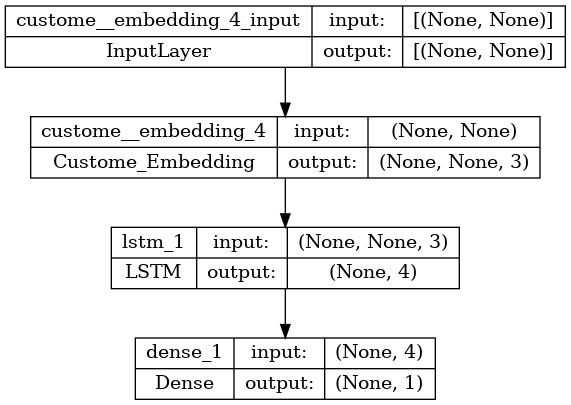

In [14]:
model = tf.keras.Sequential()

# emb_layer = tf.keras.layers.Embedding(10, 3, input_length=10)
emb_layer = Custome_Embedding(10, 3, use_zero_vector=True)
model.add(emb_layer)
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.LSTM(units=4, use_bias=False))
model.add(tf.keras.layers.Dense(1, use_bias=False))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Freeze the LSTM and Dense layer
model.layers[1].trainable = False
model.layers[2].trainable = False
print(model.summary())
plot_model(model, show_shapes=True)

In [15]:
# Access the weights of the embedding layer
embedding_weights = model.layers[0].get_embeddings()
print(embedding_weights)

# Generate fake data
x = np.random.randint(10, size=(64, 10))
y = np.random.randint(2, size=(64, 1))
# # Train model
model.fit(x, y, epochs=2000, verbose=0, batch_size=16)

# Access the weights of the embedding layer
embedding_weights = model.layers[0].get_embeddings()
print(embedding_weights)

x1 = np.random.randint(1, 10, size=(1, 10))
print(x1)
print(model.predict(x1))
x2 = np.array([np.concatenate(([0, 0, 0, 0], x1[0]))])
print(x2)
print(model.predict(x2))
x3 = np.array([np.concatenate(([0]*200, x1[0]))])
print(x3)
print(model.predict(x3))


[[ 0.          0.          0.        ]
 [ 0.03685338  0.04870595  0.02633952]
 [ 0.04134632  0.00240731 -0.04897429]
 [-0.04147382 -0.02727254  0.00264756]
 [ 0.03205856 -0.01193479  0.0057662 ]
 [-0.01102008 -0.01688296 -0.01384509]
 [ 0.04912389 -0.00206627 -0.04158114]
 [-0.02940879 -0.03563826  0.01173321]
 [-0.02674492  0.03218159  0.00993646]
 [ 0.02655056 -0.00296802 -0.01157641]]
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.8310146e-01  1.4080100e-01 -1.6217160e-01]
 [-6.3592672e-02  9.9376656e-02 -1.4191060e-01]
 [ 7.8263961e-02 -3.4701955e-01  1.8429108e-01]
 [ 7.2479457e-02 -1.1505003e-01 -2.3234120e-02]
 [-5.0209694e-02  6.1283812e-02 -7.5720564e-02]
 [ 1.3417383e-01 -1.5852067e-01 -1.0209303e-01]
 [-8.9482918e-02  6.4001739e-02 -9.7408101e-02]
 [-1.9654693e-01  2.1723521e-01 -6.0448997e-02]
 [ 7.2147441e-03 -8.6040847e-02 -3.4679961e-04]]
[[4 1 2 1 9 2 6 6 7 9]]
1/1 [==============================] - 0s 122ms/step
[[1.4312072]]
[[0 0 0 0 4 1 2 1 9 2 6 6 7 9]]
1/1 [

In [16]:
print(emb_layer(x1))
print(emb_layer(x2))
print(emb_layer(x3))


tf.Tensor(
[[[ 0.07247946 -0.11505003 -0.02323412]
  [-0.18310146  0.140801   -0.1621716 ]
  [-0.06359267  0.09937666 -0.1419106 ]
  [-0.18310146  0.140801   -0.1621716 ]
  [ 0.00721474 -0.08604085 -0.0003468 ]
  [-0.06359267  0.09937666 -0.1419106 ]
  [ 0.13417383 -0.15852067 -0.10209303]
  [ 0.13417383 -0.15852067 -0.10209303]
  [-0.08948292  0.06400174 -0.0974081 ]
  [ 0.00721474 -0.08604085 -0.0003468 ]]], shape=(1, 10, 3), dtype=float32)
tf.Tensor(
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.07247946 -0.11505003 -0.02323412]
  [-0.18310146  0.140801   -0.1621716 ]
  [-0.06359267  0.09937666 -0.1419106 ]
  [-0.18310146  0.140801   -0.1621716 ]
  [ 0.00721474 -0.08604085 -0.0003468 ]
  [-0.06359267  0.09937666 -0.1419106 ]
  [ 0.13417383 -0.15852067 -0.10209303]
  [ 0.13417383 -0.15852067 -0.10209303]
  [-0.08948292  0.06400174 -0.0974081 ]
  [ 0.00721474 -0.0860

In [17]:
inputs = tf.random.normal([1, 10, 3])
print(inputs)
# lstm = tf.keras.layers.LSTM(4)
lstm = model.layers[1]
output = lstm(inputs)
print(output)
inputs = tf.concat([tf.zeros([1, 2, 3]), inputs], axis=1)
print(inputs)
output = lstm(inputs)
print(output)
inputs = tf.concat([tf.zeros([1, 20, 3]), inputs], axis=1)
print(inputs)
output = lstm(inputs)
print(output)
inputs =tf.zeros([1, 5, 3])
print(inputs)
output = lstm(inputs)
print(output)
inputs =tf.zeros([1, 20, 3])
print(inputs)
output = lstm(inputs)
print(output)


tf.Tensor(
[[[ 1.1926188   0.1475771  -1.2860123 ]
  [ 0.3002162   0.77920955 -1.9390206 ]
  [ 0.6820296  -0.92854106  1.5604198 ]
  [ 2.0400836   0.57333535 -1.295356  ]
  [-1.548451   -0.6710078  -0.02417372]
  [ 0.21323185  1.0312015   0.16371809]
  [ 0.216901   -1.234073    1.8418258 ]
  [ 0.24009454 -0.20778859  0.33564934]
  [-0.10377084  0.88452804 -1.7858566 ]
  [-1.708584    0.65555227  0.65634626]]], shape=(1, 10, 3), dtype=float32)
tf.Tensor([[-0.50746274  0.7828103  -0.05595973  0.32882026]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 1.1926188   0.1475771  -1.2860123 ]
  [ 0.3002162   0.77920955 -1.9390206 ]
  [ 0.6820296  -0.92854106  1.5604198 ]
  [ 2.0400836   0.57333535 -1.295356  ]
  [-1.548451   -0.6710078  -0.02417372]
  [ 0.21323185  1.0312015   0.16371809]
  [ 0.216901   -1.234073    1.8418258 ]
  [ 0.24009454 -0.20778859  0.33564934]
  [-0.10377084  0.88452804 -1.7858566 ]
  [-1.7085